In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os

# Base project directory on Google Drive
BASE_DIR = "/content/drive/MyDrive/SkinAI_Project"

# Data dirs
DATA_DIR = f"{BASE_DIR}/data"
RAW_DIR = f"{DATA_DIR}/raw"
PROCESSED_DIR = f"{DATA_DIR}/processed"

# Models + notebooks
MODELS_DIR = f"{BASE_DIR}/models"

# Outputs for graphs/reports (create if not exist)
REPORTS_DIR = f"{BASE_DIR}/reports"
FIG_DIR = f"{REPORTS_DIR}/figures"
METRICS_DIR = f"{REPORTS_DIR}/metrics"

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)

print("BASE_DIR :", BASE_DIR)
print("PROCESSED_DIR:", PROCESSED_DIR)
print("MODELS_DIR :", MODELS_DIR)

print("\nProcessed dir contents:")
print(os.listdir(PROCESSED_DIR))


Mounted at /content/drive
BASE_DIR : /content/drive/MyDrive/SkinAI_Project
PROCESSED_DIR: /content/drive/MyDrive/SkinAI_Project/data/processed
MODELS_DIR : /content/drive/MyDrive/SkinAI_Project/models

Processed dir contents:
['text_augmented.csv', 'test_predictions.csv', 'structured', 'disease', 'unlabeled_text.csv', 'text_merged.csv', 'text_cleaned.csv', 'val.csv', 'text_cleaned_grouped6.csv', 'train.csv', 'text_cleaned_normalized.csv', 'dataset_health_report.csv', 'test.csv']


In [2]:
import pandas as pd
import os

train_path = os.path.join(PROCESSED_DIR, "train.csv")
val_path   = os.path.join(PROCESSED_DIR, "val.csv")
test_path  = os.path.join(PROCESSED_DIR, "test.csv")

df_train = pd.read_csv(train_path)
df_val   = pd.read_csv(val_path)
df_test  = pd.read_csv(test_path)

print("Train shape:", df_train.shape)
print("Val shape  :", df_val.shape)
print("Test shape :", df_test.shape)

print("\nTrain columns:", df_train.columns.tolist())
print("Val columns  :", df_val.columns.tolist())
print("Test columns :", df_test.columns.tolist())

print("\nSample train rows:")
display(df_train.head())

print("Null counts (train):")
print(df_train.isna().sum())

print("\nLabel distribution (train, top 30):")
print(df_train["label"].value_counts().head(30))

num_classes = df_train["label"].nunique()
print("\nNumber of unique labels in train:", num_classes)


Train shape: (7433, 3)
Val shape  : (1593, 3)
Test shape : (1593, 3)

Train columns: ['text', 'label', 'source']
Val columns  : ['text', 'label', 'source']
Test columns : ['text', 'label', 'source']

Sample train rows:


,text,label,source
0,"age: 68 | gender: male | symptom text: lately,...",Contact dermatitis (Irritant),synthetic/clinical_cases_10000.csv
1,age: 56 | gender: male | symptom text: recentl...,Tinea cruris (Jock itch),synthetic/clinical_cases_10000.csv
2,age: 48 | gender: male | symptom text: these d...,Cellulitis,synthetic/clinical_cases_10000.csv
3,age: 35 | gender: male | symptom text: i've no...,Seborrheic dermatitis,synthetic/clinical_cases_10000.csv
4,age: 48 | gender: female | symptom text: recen...,Impetigo,synthetic/clinical_cases_10000.csv


Null counts (train):
text      0
label     0
source    0
dtype: int64

Label distribution (train, top 30):
label
Tinea corporis (Ringworm)         275
Urticaria (Hives)                 269
Impetigo                          268
Seborrheic dermatitis             264
Dyshidrotic eczema                257
Herpes simplex (Cold sores)       253
Rosacea                           253
Pityriasis versicolor             252
Lichen planus                     248
Folliculitis                      248
Acne vulgaris                     248
Tinea capitis (Scalp ringworm)    246
Contact dermatitis (Irritant)     246
Perioral dermatitis               246
Tinea cruris (Jock itch)          245
Molluscum contagiosum             245
Chronic urticaria                 244
Vitiligo                          243
Nummular eczema                   242
Scabies                           239
Acne rosacea                      236
Cellulitis                        234
Psoriasis vulgaris                234
Contact derma

In [3]:
# Features and labels
X_train = df_train["text"].astype(str).tolist()
y_train = df_train["label"].astype(str).tolist()

X_val = df_val["text"].astype(str).tolist()
y_val = df_val["label"].astype(str).tolist()

X_test = df_test["text"].astype(str).tolist()
y_test = df_test["label"].astype(str).tolist()

print("\nExamples:")
for i in range(3):
    print(f"[{i}] label={y_train[i]} | text={X_train[i][:120]}...")



Examples:
[0] label=Contact dermatitis (Irritant) | text=age: 68 | gender: male | symptom text: lately, for around 6 months, i've had redness and itching on my hands/arms after ...
[1] label=Tinea cruris (Jock itch) | text=age: 56 | gender: male | symptom text: recently, for the last 5 weeks, i've had an itchy rash in the groin area. it come...
[2] label=Cellulitis | text=age: 48 | gender: male | symptom text: these days, for the last 7 weeks, i've had redness with swelling and warmth aroun...


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),   # unigrams + bigrams
    max_features=5000,    # tuneable
    min_df=2,             # ignore rare terms
    max_df=0.9            # ignore too frequent terms
)

# Fit on train only
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf   = vectorizer.transform(X_val)
X_test_tfidf  = vectorizer.transform(X_test)

print("TF-IDF shapes:")
print(" X_train:", X_train_tfidf.shape)
print(" X_val  :", X_val_tfidf.shape)
print(" X_test :", X_test_tfidf.shape)


TF-IDF shapes:
 X_train: (7433, 4572)
 X_val  : (1593, 4572)
 X_test : (1593, 4572)


In [5]:
from sklearn.svm import LinearSVC

# Base SVM model (no probabilities)
svm_base = LinearSVC(class_weight="balanced", random_state=42)

print("Training LinearSVC (base) on TRAIN...")
svm_base.fit(X_train_tfidf, y_train)
print("Training finished.")


Training LinearSVC (base) on TRAIN...
Training finished.


In [6]:
from sklearn.calibration import CalibratedClassifierCV

# Calibrate probabilities using validation set (prefit)
svm_cal = CalibratedClassifierCV(
    estimator=svm_base,
    method="sigmoid",
    cv="prefit"
)

print("Calibrating probabilities using VALIDATION set...")
svm_cal.fit(X_val_tfidf, y_val)
print("Calibration finished.")


Calibrating probabilities using VALIDATION set...


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Calibration finished.


In [7]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_split(name, model, X, y_true):
    y_pred = model.predict(X)
    acc = accuracy_score(y_true, y_pred)
    print(f"\n=== {name} ===")
    print("Accuracy:", round(acc, 4))
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    return y_pred, acc

# Train
y_pred_train, acc_train = evaluate_split("TRAIN", svm_cal, X_train_tfidf, y_train)

# Validation
y_pred_val, acc_val = evaluate_split("VALIDATION", svm_cal, X_val_tfidf, y_val)

# Test
y_pred_test, acc_test = evaluate_split("TEST", svm_cal, X_test_tfidf, y_test)



=== TRAIN ===
Accuracy: 0.8087

Classification report:
                                precision    recall  f1-score   support

                          Acne       1.00      1.00      1.00        21
                  Acne rosacea       1.00      1.00      1.00       236
                 Acne vulgaris       1.00      1.00      1.00       248
             Actinic keratosis       1.00      1.00      1.00        25
    Athlete Foot (Tinea Pedis)       1.00      0.88      0.93         8
  Athlete's Foot (Tinea Pedis)       0.89      1.00      0.94         8
             Atopic Dermatitis       1.00      1.00      1.00        25
    Atopic dermatitis (Eczema)       0.34      0.32      0.33       228
              Benign keratosis       1.00      1.00      1.00        28
                    Cellulitis       1.00      1.00      1.00       234
             Chronic urticaria       1.00      1.00      1.00       244
            Contact Dermatitis       1.00      1.00      1.00        10
 Contac

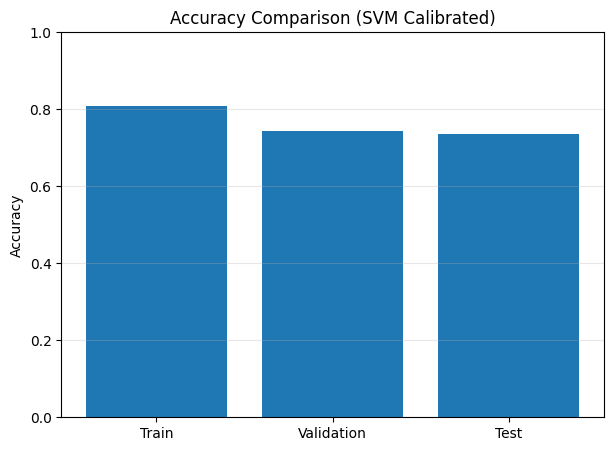

Saved: /content/drive/MyDrive/SkinAI_Project/reports/figures/svm_calibrated_accuracy_bar.png


In [8]:
import matplotlib.pyplot as plt

accuracies = {
    "Train": acc_train,
    "Validation": acc_val,
    "Test": acc_test
}

plt.figure(figsize=(7,5))
plt.bar(accuracies.keys(), accuracies.values())
plt.title("Accuracy Comparison (SVM Calibrated)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, axis="y", alpha=0.3)

out_path = os.path.join(FIG_DIR, "svm_calibrated_accuracy_bar.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out_path)


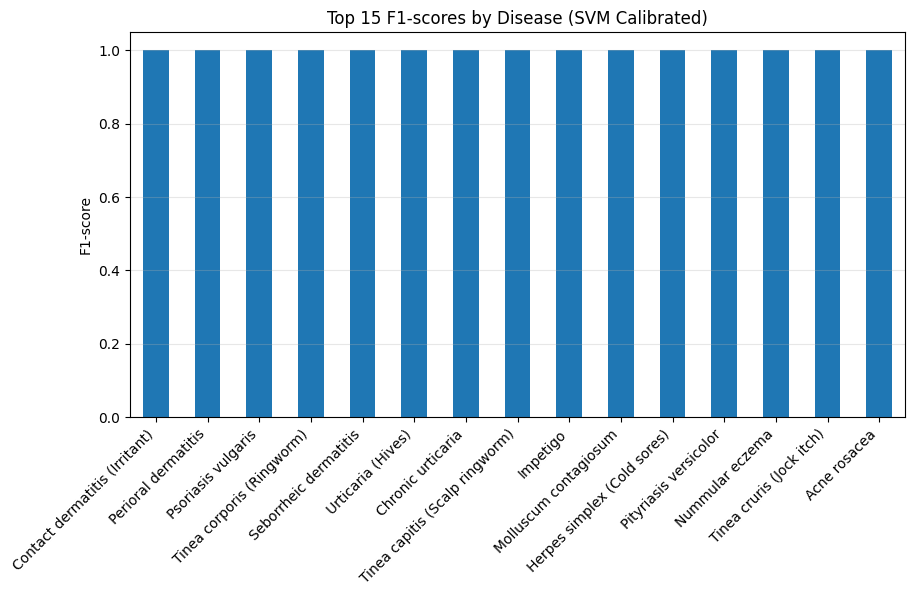

Saved: /content/drive/MyDrive/SkinAI_Project/reports/figures/svm_calibrated_top15_f1.png


In [9]:
from sklearn.metrics import f1_score
import pandas as pd

unique_labels = df_test["label"].unique()
f1_scores = {}

for label in unique_labels:
    f1_scores[label] = f1_score(y_test, y_pred_test, labels=[label], average="macro")

pd.Series(f1_scores).sort_values(ascending=False).head(15).plot(kind="bar", figsize=(10,5))
plt.title("Top 15 F1-scores by Disease (SVM Calibrated)")
plt.ylabel("F1-score")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", alpha=0.3)

out_path = os.path.join(FIG_DIR, "svm_calibrated_top15_f1.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out_path)


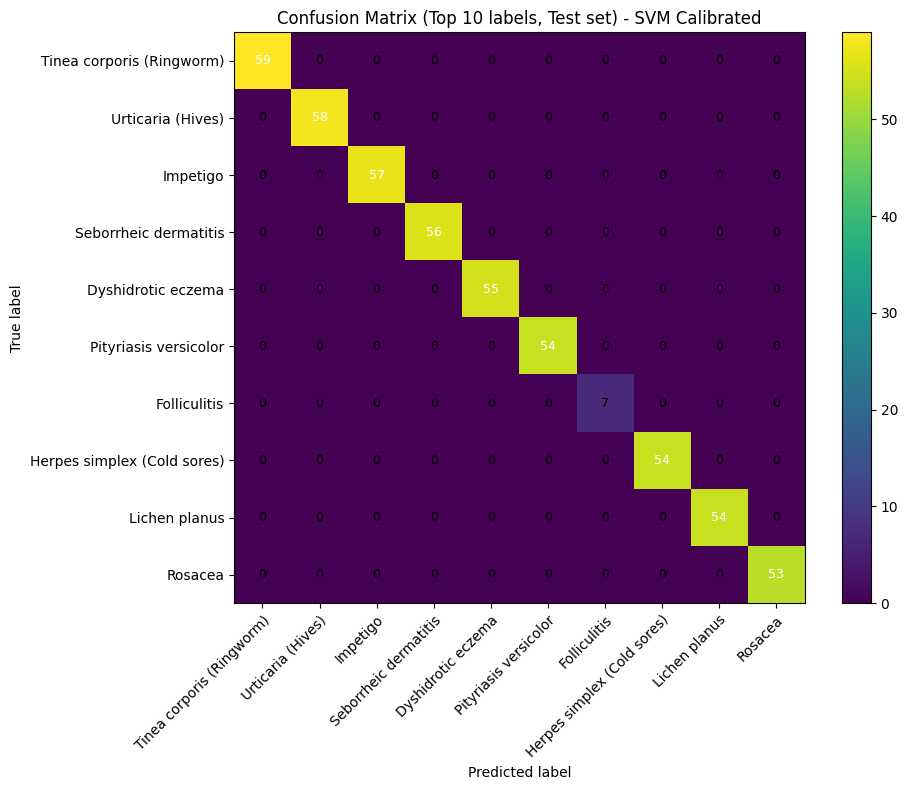

Saved: /content/drive/MyDrive/SkinAI_Project/reports/figures/svm_calibrated_confusion_top10.png


In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get top N labels by frequency in test set
N = 10
label_counts = pd.Series(y_test).value_counts().head(N)
top_labels = label_counts.index.tolist()

# Filter to top N labels
mask = [y in top_labels for y in y_test]
y_true_top = np.array(y_test)[mask]
y_pred_top = np.array(y_pred_test)[mask]

cm = confusion_matrix(y_true_top, y_pred_top, labels=top_labels)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, interpolation="nearest")
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(len(top_labels)),
    yticks=np.arange(len(top_labels)),
    xticklabels=top_labels,
    yticklabels=top_labels,
    ylabel="True label",
    xlabel="Predicted label",
    title=f"Confusion Matrix (Top {N} labels, Test set) - SVM Calibrated"
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate cells (show ALL numbers including zeros if you want)
thresh = cm.max() / 2. if cm.max() > 0 else 0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        val = cm[i, j]
        ax.text(
            j, i, format(val, "d"),
            ha="center", va="center",
            color="white" if val > thresh else "black",
            fontsize=9
        )

plt.tight_layout()

out_path = os.path.join(FIG_DIR, "svm_calibrated_confusion_top10.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out_path)


VAL Log Loss : 0.7934
TEST Log Loss: 0.8255


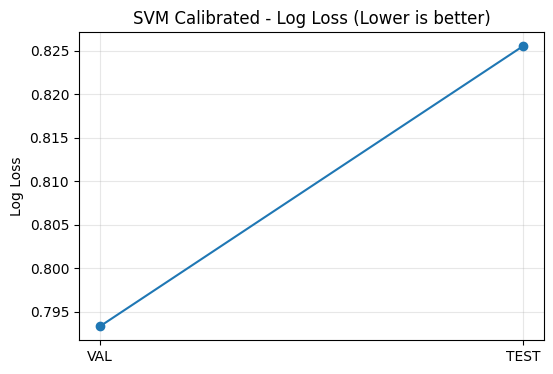

Saved: /content/drive/MyDrive/SkinAI_Project/reports/figures/svm_calibrated_logloss.png
TEST Brier Score (Lower is better): 0.2902


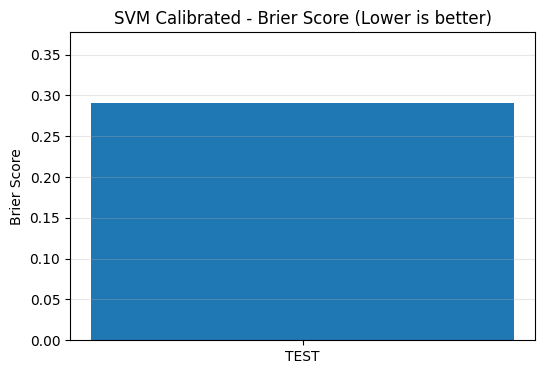

Saved: /content/drive/MyDrive/SkinAI_Project/reports/figures/svm_calibrated_brier.png


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.preprocessing import label_binarize

# Probabilities from calibrated SVM
val_probs = svm_cal.predict_proba(X_val_tfidf)
test_probs = svm_cal.predict_proba(X_test_tfidf)

# Log loss
val_logloss = log_loss(y_val, val_probs, labels=svm_cal.classes_)
test_logloss = log_loss(y_test, test_probs, labels=svm_cal.classes_)

print("VAL Log Loss :", round(val_logloss, 4))
print("TEST Log Loss:", round(test_logloss, 4))

plt.figure(figsize=(6,4))
plt.plot(["VAL", "TEST"], [val_logloss, test_logloss], marker="o")
plt.title("SVM Calibrated - Log Loss (Lower is better)")
plt.ylabel("Log Loss")
plt.grid(True, alpha=0.3)
out_path = os.path.join(FIG_DIR, "svm_calibrated_logloss.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out_path)

# Brier score (multi-class)
y_test_bin = label_binarize(y_test, classes=svm_cal.classes_)
brier = np.mean(np.sum((y_test_bin - test_probs)**2, axis=1))
print("TEST Brier Score (Lower is better):", round(float(brier), 4))

plt.figure(figsize=(6,4))
plt.bar(["TEST"], [brier])
plt.title("SVM Calibrated - Brier Score (Lower is better)")
plt.ylabel("Brier Score")
plt.ylim(0, max(brier * 1.3, 0.05))
plt.grid(True, axis="y", alpha=0.3)
out_path = os.path.join(FIG_DIR, "svm_calibrated_brier.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out_path)


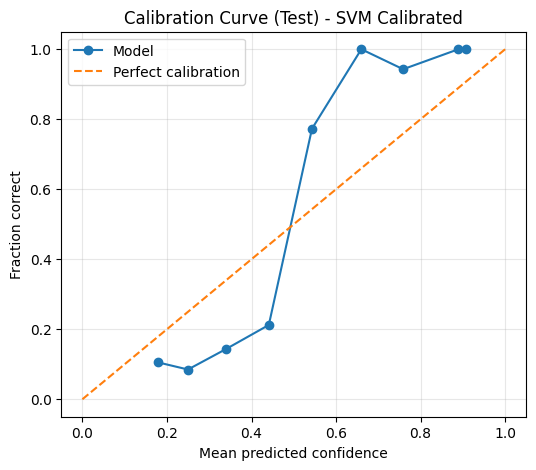

Saved: /content/drive/MyDrive/SkinAI_Project/reports/figures/svm_calibrated_calibration_curve.png


In [12]:
from sklearn.calibration import calibration_curve
import numpy as np
import matplotlib.pyplot as plt

# Confidence = max predicted probability
conf_test = test_probs.max(axis=1)
correct_test = (np.array(y_pred_test) == np.array(y_test)).astype(int)

frac_pos, mean_pred = calibration_curve(correct_test, conf_test, n_bins=10, strategy="uniform")

plt.figure(figsize=(6,5))
plt.plot(mean_pred, frac_pos, marker="o", label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")
plt.title("Calibration Curve (Test) - SVM Calibrated")
plt.xlabel("Mean predicted confidence")
plt.ylabel("Fraction correct")
plt.grid(True, alpha=0.3)
plt.legend()

out_path = os.path.join(FIG_DIR, "svm_calibrated_calibration_curve.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out_path)


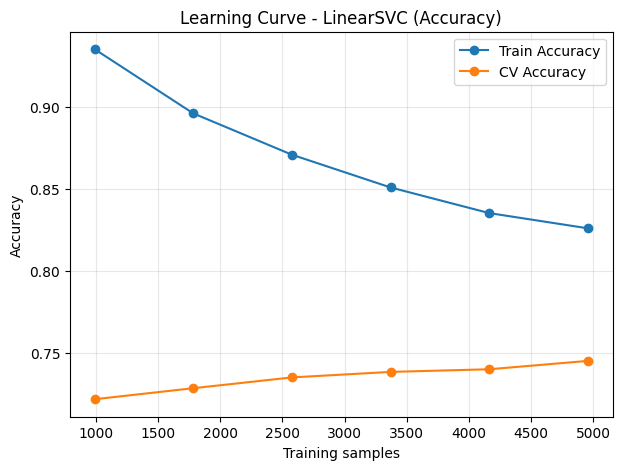

Saved: /content/drive/MyDrive/SkinAI_Project/reports/figures/svm_learning_curve.png


In [13]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, cv_scores = learning_curve(
    estimator=LinearSVC(class_weight="balanced", random_state=42),
    X=X_train_tfidf,
    y=y_train,
    train_sizes=np.linspace(0.2, 1.0, 6),
    cv=3,
    scoring="accuracy"
)

train_mean = train_scores.mean(axis=1)
cv_mean = cv_scores.mean(axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, marker="o", label="Train Accuracy")
plt.plot(train_sizes, cv_mean, marker="o", label="CV Accuracy")
plt.title("Learning Curve - LinearSVC (Accuracy)")
plt.xlabel("Training samples")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()

out_path = os.path.join(FIG_DIR, "svm_learning_curve.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out_path)


In [14]:
import joblib
import os

os.makedirs(MODELS_DIR, exist_ok=True)

MODEL_PATH = os.path.join(MODELS_DIR, "skin_text_classifier_tfidf_svm_calibrated.joblib")
VECT_PATH  = os.path.join(MODELS_DIR, "vectorizer_tfidf.joblib")

joblib.dump(svm_cal, MODEL_PATH)
joblib.dump(vectorizer, VECT_PATH)

print("Saved classifier to:", MODEL_PATH)
print("Saved vectorizer to :", VECT_PATH)


Saved classifier to: /content/drive/MyDrive/SkinAI_Project/models/skin_text_classifier_tfidf_svm_calibrated.joblib
Saved vectorizer to : /content/drive/MyDrive/SkinAI_Project/models/vectorizer_tfidf.joblib


In [15]:
def predict_with_confidence(model, vectorizer, text: str):
    """
    Predict label + confidence for Calibrated SVM.
    confidence = predicted class probability (0..1) if predict_proba exists.
    """
    X = vectorizer.transform([text])
    pred = model.predict(X)[0]

    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)[0]
        classes = list(model.classes_)
        conf = float(proba[classes.index(pred)])
        return pred, conf

    return pred, None

samples = [
    "I have pimples and red bumps with white pus on my cheeks and forehead.",
    "My skin is very dry and itchy with red patches that crack sometimes.",
    "I have a circular itchy rash with raised red border and clear center."
]

for s in samples:
    p, c = predict_with_confidence(svm_cal, vectorizer, s)  # ✅ use svm_cal here
    print("\nTEXT:", s)
    print("PRED:", p)
    print("CONF:", "N/A" if c is None else f"{c*100:.2f}%")



TEXT: I have pimples and red bumps with white pus on my cheeks and forehead.
PRED: Folliculitis
CONF: 56.33%

TEXT: My skin is very dry and itchy with red patches that crack sometimes.
PRED: Folliculitis
CONF: 12.35%

TEXT: I have a circular itchy rash with raised red border and clear center.
PRED: Folliculitis
CONF: 15.18%


In [16]:
import numpy as np

def predict_topk(model, vectorizer, text: str, k: int = 3):
    X = vectorizer.transform([text])

    if not hasattr(model, "predict_proba"):
        pred = model.predict(X)[0]
        return [(pred, None)]

    proba = model.predict_proba(X)[0]
    classes = np.array(model.classes_)
    top_idx = np.argsort(proba)[::-1][:k]

    return [(classes[i], float(proba[i])) for i in top_idx]

samples = [
    "I have pimples and red bumps with white pus on my cheeks and forehead.",
    "My skin is very dry and itchy with red patches that crack sometimes.",
    "I have a circular itchy rash with raised red border and clear center."
]

for s in samples:
    top3 = predict_topk(svm_cal, vectorizer, s, k=3)  # ✅ svm_cal here
    print("\nTEXT:", s)
    for rank, (lbl, conf) in enumerate(top3, 1):
        print(f"Top-{rank}: {lbl} | {conf*100:.2f}%")



TEXT: I have pimples and red bumps with white pus on my cheeks and forehead.
Top-1: Folliculitis | 56.33%
Top-2: Vitiligo | 6.28%
Top-3: Scabies | 4.15%

TEXT: My skin is very dry and itchy with red patches that crack sometimes.
Top-1: Folliculitis | 12.35%
Top-2: Contact dermatitis (Allergic) | 10.97%
Top-3: Atopic dermatitis (Eczema) | 8.99%

TEXT: I have a circular itchy rash with raised red border and clear center.
Top-1: Folliculitis | 15.18%
Top-2: Tinea corporis (Ringworm) | 11.98%
Top-3: Atopic dermatitis (Eczema) | 7.57%
